In [1]:
import torch
import pyro
from pyro.infer import MCMC, NUTS
import pyro.distributions as dist
import pandas as pd
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

/Users/fraserbrown/projects/bayesian_logistic_regression/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Data

In [4]:
df = pd.read_csv('heart.csv')

# Feature Engineering

In [6]:
def df_processing(raw_data: pd.DataFrame) -> pd.DataFrame:
    ## FastingBS is a categorical variable which has already been binary encoded. Treat as a categorical variable
    raw_data['FastingBS'] = raw_data['FastingBS'].replace({0: 'N', 1: 'Y'})
    # Extract categorical features
    categorical_features = raw_data.select_dtypes(include= 'object')
    # Extract numeric features and convert to float
    numerical_features = raw_data.select_dtypes(include = 'int64')
    numerical_features = numerical_features.astype('float')
    ## Use standing scaling method for continuous numerical columns
    for col in numerical_features.columns:
        if col != 'HeartDisease':
            numerical_features[col] = numerical_features[col].apply(lambda x: \
                                                                (x - numerical_features[col].mean())/numerical_features[col].std())
    # Apply One-hot encoding to categorical features
    categorical_features_encoded = pd.get_dummies(categorical_features, dtype= 'float')
    # Concatenate processed numercial and categorical features 
    df_processed = pd.concat([numerical_features, categorical_features_encoded], axis = 1)

    return df_processed

df_processed = df_processing(df)

# Split into training and test data

In [7]:
def split_data(data: pd.DataFrame, target: str, training_size: float) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # Calculate the number of rows for training based on the training_size
    N = int(round(training_size * len(data)))

    # Split data into training and test
    training_data = data.sample(len(data))[:N]
    test_data = data.sample(len(data))[N:]

    # Split data into feature and target sets
    x_training, y_training = training_data.drop(columns=[target], axis=1), training_data[[target]]
    x_test, y_test = test_data.drop(columns=[target], axis=1), test_data[[target]]

    # Convert to tensors as type float
    x_training, y_training, x_test, y_test = (
        torch.tensor(x_training.to_numpy()).float(),
        torch.tensor(y_training.to_numpy()).float(),
        torch.tensor(x_test.to_numpy()).float(),
        torch.tensor(y_test.to_numpy()).float(),
    )

    return x_training, y_training, x_test, y_test

# Split data into training and test sets
x_training, y_training, x_test, y_test = split_data(df_processed, 'HeartDisease', 0.8)

# MCMC Inference

In [8]:
NUM_OF_SAMPLES = 1000
NUM_OF_CHAINS = 4

In [9]:
def logistic_regression_model(features: torch.Tensor, target: torch.Tensor):
    # sample from prior
    W = pyro.sample(
        "weight", dist.Normal(torch.zeros(1, features.shape[1]), torch.ones(1, features.shape[1])).independent(1)
    )
    b = pyro.sample(
        "bias", dist.Normal(torch.zeros(1), torch.ones(1)).independent(1)
    )
    with pyro.plate("data", features.size(0)):
        model_logits = (torch.matmul(features, W.permute(1, 0)) + b).squeeze() 
        probs = torch.sigmoid(model_logits)
        pyro.sample(
            "obs", 
            dist.Bernoulli(probs=probs),
            obs=target.squeeze())

def run_inference(features: torch.Tensor, target: torch.Tensor, number_of_samples: int, number_of_chains:int) -> MCMC:
    kernel = NUTS(logistic_regression_model)
    mcmc = MCMC(kernel, num_samples = number_of_samples, warmup_steps = 200, num_chains=number_of_chains)
    mcmc.run(features.float(), target.float())
    return mcmc

In [10]:
# Run MCMC Sampling
mcmc = run_inference(x_training, y_training, number_of_samples=NUM_OF_SAMPLES, number_of_chains=NUM_OF_CHAINS)

/Users/fraserbrown/projects/bayesian_logistic_regression/.venv/lib/python3.9/site-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=4 is more than available_cpu=3. Chains will be drawn sequentially.
  warnings.warn(
Sample [3]: 100%|██████████| 1200/1200 [04:00,  4.98it/s, step size=8.40e-02, acc. prob=0.938]


In [11]:
# Print sampling summary
mcmc.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     bias[0]     -0.04      0.84     -0.05     -1.52      1.24   3249.48      1.00
 weight[0,0]      0.11      0.14      0.11     -0.11      0.34   4893.57      1.00
 weight[0,1]      0.13      0.14      0.13     -0.10      0.36   5060.60      1.00
 weight[0,2]      0.11      0.13      0.11     -0.10      0.32   5299.78      1.00
 weight[0,3]     -0.34      0.13     -0.34     -0.54     -0.12   5568.86      1.00
 weight[0,4]     -0.18      0.15     -0.18     -0.43      0.06   5176.35      1.00
 weight[0,5]     -0.84      0.66     -0.85     -1.88      0.27   3207.91      1.00
 weight[0,6]      0.81      0.66      0.80     -0.25      1.92   3124.93      1.00
 weight[0,7]      1.29      0.53      1.29      0.44      2.14   2145.16      1.00
 weight[0,8]     -0.70      0.55     -0.70     -1.64      0.17   2279.65      1.00
 weight[0,9]     -0.46      0.53     -0.47     -1.34      0.45   2102.04      1.00
wei

# Create Dataframes of samples for plotting

In [12]:
def generate_samples_per_parameter(mcmc_instance: MCMC) -> dict:
    # Retrieve samples
    ungrouped_samples = mcmc_instance.get_samples()

    # Split the weights matrix into seperate values in dictionary
    samples_split = {}
    for i in range(x_training.shape[1]):
        samples_split[f'weight_{i}'] = ungrouped_samples['weight'].squeeze(1)[:,i]

    samples_split['bias'] = ungrouped_samples['bias'].squeeze()

    return samples_split

def generate_trace_df(samples:dict) -> pd.DataFrame:
    trace = pd.DataFrame(samples)
    trace['sample_number'] =  range(len(trace))

    melted = pd.melt(trace, id_vars = ['sample_number'])
    melted.columns = ['sample_number','parameter', 'value']
    
    return melted

# dictionary of samples
samples = generate_samples_per_parameter(mcmc)

# df of samples per paramater
trace_df = generate_trace_df(samples)

# Trace and Kernel Density Plot Examples

Text(0.5, 1.0, 'Weight_0 Kernel Density Function')

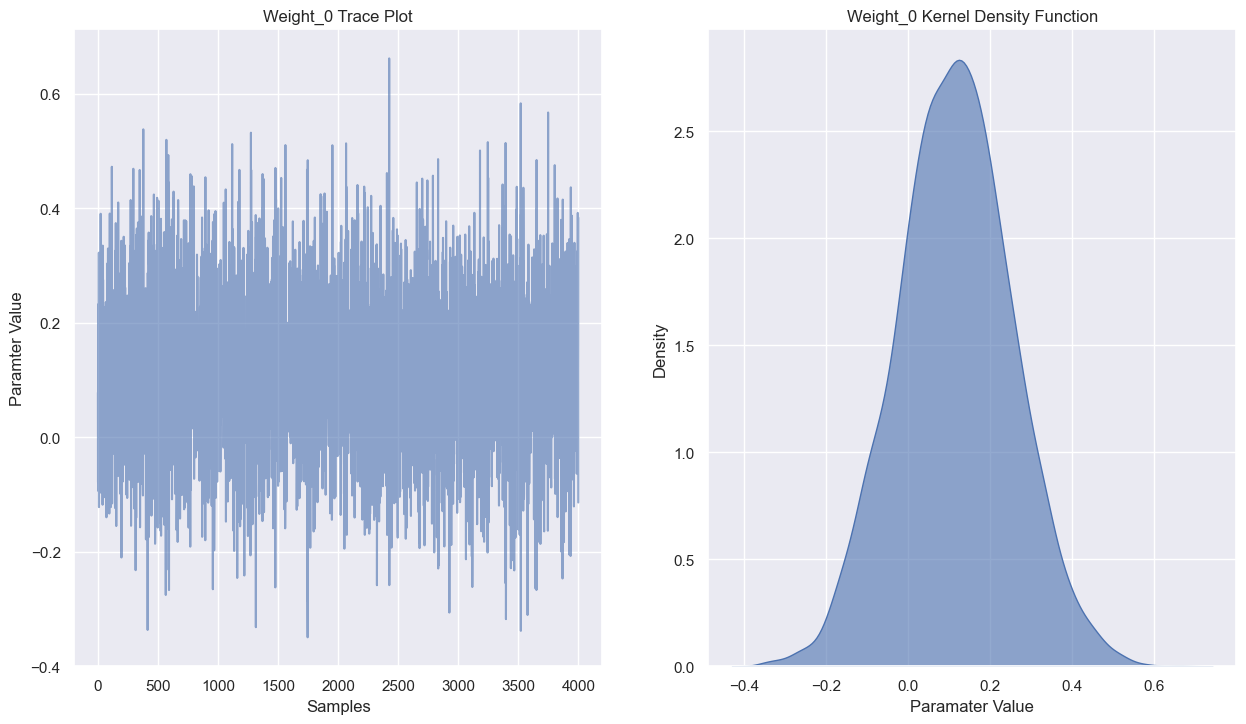

In [13]:
# Using the first feature as an example -> 'weight_0'
sns.set(rc={'figure.figsize':(15,8.27)})
fig, axes = plt.subplots(1, 2)

sns.lineplot(data = trace_df[trace_df['parameter']=='weight_0'], x = 'sample_number', y = 'value', ax = axes[0], alpha = 0.6)
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Paramter Value')
axes[0].set_title('Weight_0 Trace Plot')

sns.kdeplot(data = trace_df[trace_df['parameter']=='weight_0'], x = 'value', ax = axes[1], fill = True, alpha =0.6)
axes[1].set_xlabel('Paramater Value')
axes[1].set_ylabel('Density')
axes[1].set_title('Weight_0 Kernel Density Function')

# Produce Density Plot for each chain of first feature

Text(0.5, 1.0, 'Weight_0 Kernel Density Function')

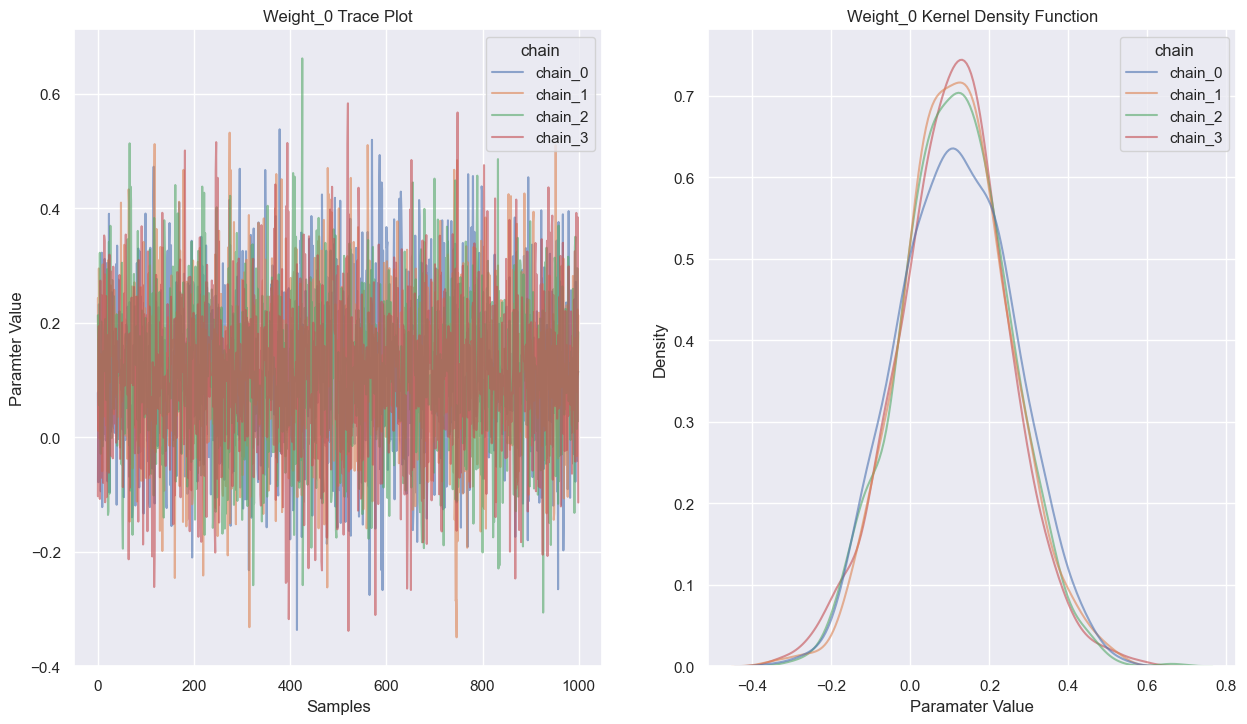

In [14]:
# This code extracts the samples drawn by each chain for the first feature in the feature set,to visually demonstrate convergence.
weight_0 = mcmc.get_samples(group_by_chain=True)['weight'].squeeze()[:,:,0].permute(1,0)

weight_0_chains = pd.DataFrame(weight_0)
weight_0_chains.columns = [f'chain_{i}' for i in range(4)]
weight_0_chains['sample_number'] =  range(len(weight_0_chains))

melted_chains = pd.melt(weight_0_chains, id_vars = ['sample_number'])

melted_chains.columns = ['sample_number', 'chain', 'parameter_value']

sns.set(rc={'figure.figsize':(15,8.27)})
fig, axes = plt.subplots(1, 2)
sns.lineplot(data = melted_chains, x = 'sample_number', y = 'parameter_value', hue = 'chain' ,ax = axes[0], alpha = 0.6)

axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Paramter Value')
axes[0].set_title('Weight_0 Trace Plot')

sns.kdeplot(data = melted_chains, x = 'parameter_value', ax = axes[1], hue = 'chain' ,  alpha =0.6)
axes[1].set_xlabel('Paramater Value')
axes[1].set_ylabel('Density')
axes[1].set_title('Weight_0 Kernel Density Function')

# Generate training and test set predictions

In [15]:
def create_predictions(samples: dict, dataset: torch.tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

    obs_samples = torch.zeros(samples["weight"].shape[0], dataset.shape[0])

    for i in range(samples["weight"].shape[0]):
        W_sample = samples["weight"][i]
        b_sample = samples["bias"][i]

        model_logits = (torch.matmul(dataset, W_sample.permute(1, 0)) + b_sample).squeeze()
        probs = torch.sigmoid(model_logits)

        obs_samples[i] = probs
    
    mean_predictions = obs_samples.mean(dim=0)
    class_predictions = (obs_samples.mean(dim=0)>0.5).int()

    return class_predictions, obs_samples, mean_predictions

# Draw ungrouped samples
samples_ungrouped = mcmc.get_samples()

# Training predictions
train_class_predictions, train_prediction_samples, train_mean_predictions = create_predictions(samples_ungrouped, x_training)
# Test predictions
test_class_predictions, test_prediction_samples,test_mean_predictions = create_predictions(samples_ungrouped, x_test)

# Plot the Distributions of Model Predictions for a Random Example

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


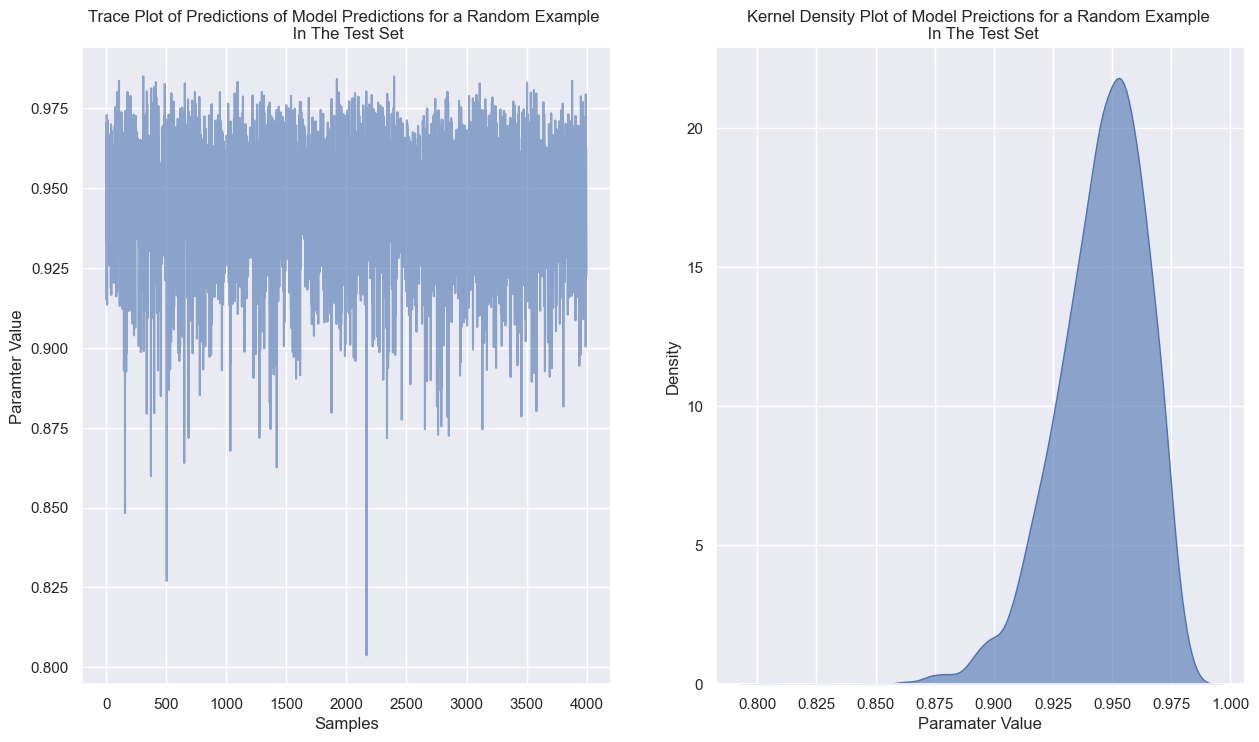

In [17]:
first_example_model_outputs = pd.DataFrame(test_prediction_samples[:,7])

# Using the first feature as an example -> 'weight_0'
sns.set(rc={'figure.figsize':(15,8.27)})
fig, axes = plt.subplots(1, 2)

sns.lineplot(data = first_example_model_outputs, ax = axes[0], alpha = 0.6)
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Paramter Value')
axes[0].set_title('Trace Plot of Predictions of Model Predictions for a Random Example \n In The Test Set')
axes[0].legend().remove()

sns.kdeplot(data = first_example_model_outputs, ax = axes[1], fill = True, alpha =0.6)
axes[1].set_xlabel('Paramater Value')
axes[1].set_ylabel('Density')
axes[1].set_title('Kernel Density Plot of Model Preictions for a Random Example \n In The Test Set')
axes[1].legend().remove()

# Create evaluation metrics

In [18]:
def calculate_classification_metrics(true_labels:torch.Tensor, predicted_labels:torch.Tensor, prob_scores:torch.Tensor) -> dict:
    metrics = {}
    
    # Accuracy
    metrics['Accuracy'] = accuracy_score(true_labels, predicted_labels)

    # Precision
    metrics['Precision'] = precision_score(true_labels, predicted_labels)

    # Recall
    metrics['Recall'] = recall_score(true_labels, predicted_labels)

    # F1 Score
    metrics['F1 Score'] = f1_score(true_labels, predicted_labels)

    # ROC Curve
    metrics['ROC Score']  = roc_curve(true_labels, prob_scores)

    # AUC-ROC
    metrics['AUC-ROC'] = roc_auc_score(true_labels, prob_scores)

    return metrics

# Evaluation Metrics for Test Data

In [19]:
metrics_test = calculate_classification_metrics(y_test, test_class_predictions, test_mean_predictions)
df_test = pd.DataFrame(metrics_test).drop(columns = ['ROC Score'], axis =1).drop_duplicates()
df_test.index = ['Test']
for metric, value in metrics_test.items():
    if metric != 'ROC Score':
        print(f"{metric}: {value}")

Accuracy: 0.8641304347826086
Precision: 0.8640776699029126
Recall: 0.89
F1 Score: 0.8768472906403941
AUC-ROC: 0.9408333333333333


# Evaluation Metrics for Training Data

In [20]:
metrics_training = calculate_classification_metrics(y_training, train_class_predictions, train_mean_predictions)
df_training = pd.DataFrame(metrics_training).drop(columns = ['ROC Score'], axis =1).drop_duplicates()
df_training.index = ['Training']
for metric, value in metrics_training.items():
    if metric != 'ROC Score':
        print(f"{metric}: {value}")


Accuracy: 0.8583106267029973
Precision: 0.8581560283687943
Recall: 0.8918918918918919
F1 Score: 0.8746987951807228
AUC-ROC: 0.9337360713507502


In [21]:
df_metrics_summary = pd.concat([df_training, df_test])
df_metrics_summary.transpose().round(2)

,Training,Test
Accuracy,0.86,0.86
Precision,0.86,0.86
Recall,0.89,0.89
F1 Score,0.87,0.88
AUC-ROC,0.93,0.94


# Plot the ROC curve.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


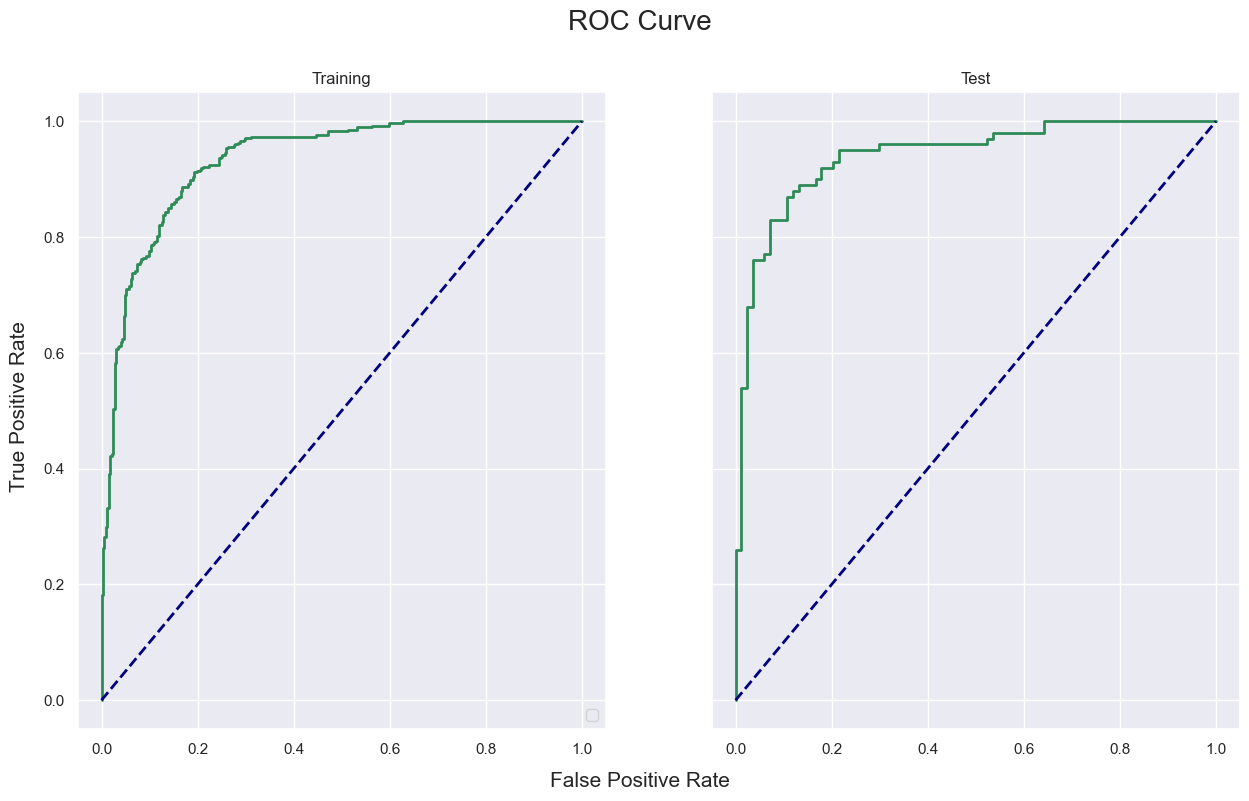

<Figure size 800x600 with 0 Axes>

In [22]:
# Plot ROC curve
fig, axes = plt.subplots(1,2, sharey=True)
plt.figure(figsize=(8, 6))
axes[1].plot(metrics_test['ROC Score'][0], metrics_test['ROC Score'][1], color='seagreen', lw=2)
axes[0].plot(metrics_training['ROC Score'][0], metrics_training['ROC Score'][1], color='seagreen', lw=2)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Training')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center', fontsize = 15)
fig.text(0.08, 0.5, 'True Positive Rate', va='center', rotation='vertical', fontsize = 15)
fig.suptitle('ROC Curve', fontsize = 20)
axes[1].set_title('Test')
axes[0].legend(loc="lower right")
plt.show()